In [ ]:
# default_exp avi

# AVI Module

> This module is a class that makes it easier to interface with the Dataset modules. The module can be used to load a single frame from a particular video in the dataset.

Finally 
Note: The original dataset is relatively small (9.5GB). However, it can be extremely slow to load and decode video files from memory. Because of this, sometime (e.g. here) video files are stored as numpy arrays of size [sequence_length,height,width,3]. This makes them very quick to load but extremely large (~500GB). In this case, the dataset is stored as hdf5 files. This function can also convert the avi paths to hdf5.

In [ ]:
#hide
from nbdev.showdoc import *

In [2]:
#export
import numpy as np
import cv2
import pathlib
import matplotlib.pyplot as plt
from PIL import Image

import torch

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
#export
class AVI:
    def __init__(self, filename, toPIL=False, verbose=False, safe=False, img_type=np.float32):
        self._filename = pathlib.Path(filename)
        self._toPIL = toPIL
        self._verbose = verbose
        self._safeframes = safe # is True, getSequence will go back in time to find one good frame.
        self._img_type = img_type # this is only used if toPIL = False
        cap = cv2.VideoCapture(self._filename.as_posix())   
        self._attributes = {}
        self._attributes['n-frames']     = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self._attributes['frame-height'] = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self._attributes['frame-width']  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._attributes['channels']    = None # default
        self._attributes['fps']         = cap.get(cv2.CAP_PROP_FPS)
        
        # call this function here to update some attributes that are only available once a frame is grabbed.
        self.getFrame(0)
        
        cap.release()  
        
    def __len__(self):
        return self._attributes['n-frames']
 
    def getFrame(self, frame_index, circular=False):
        """Loads a single frame from a file at index frame_index.
        
        The data is returned and is a numpy array of size [n_channels, height, width] of type np.float32.
        If circular == True, wraps frame_index to the number of frames 
        """
        ### load file from AVI
        cap = cv2.VideoCapture(self._filename.as_posix())   
 
        if not cap.isOpened(): 
            print(f"could not open {self._filename.as_posix()}") 
            frame = np.array([])
            return frame

        if circular: frame_index = frame_index % self._attributes['n-frames']
        self._attributes['frame-index']  = frame_index;                
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
        ret, frame = cap.read()  
        if frame is None:
            if self._verbose: print(f'ERROR in file: {self._filename.as_posix()}, frame-index: {frame_index}.')
            return frame
        cap.release()            
                          
        if len(frame.shape) == 2:
            self._attributes['channels'] = 2
        else:
            self._attributes['channels'] = frame.shape[2]
                    
        if self._toPIL: # .transpose(2,0,1)
            cv2_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(cv2_im)            
        else:
            #frame = frame.astype(np.float32)
            #frame = frame.astype(np.uint8) # !!!
            frame = frame.astype(self._img_type)
            
        return frame
    
    def getRandomFrame(self, max_attempts=100):
        frame = None
        count = 0
        frame_index = None
        while frame is None and count < max_attempts:
            count += 1
            if frame_index is None:
                frame_index = np.random.randint(self._attributes['n-frames'])
                frame = self.getFrame(frame_index) 
                if frame is None:
                    if self._verbose: print(f'ERROR in file: {self._filename}, frame_index: {frame_index}. Retrying with different random frame number.')
                    frame_index = None
        return frame
    
    def getFrames(self, c, w, h, reshape=False, to_net_shape=False, normalise=False):
        # c, w, h = channels, width, heigth
        data = np.zeros((self._attributes['n-frames'], c, w, h), dtype=np.float32)

        for j in range(self._attributes['n-frames']):       
            frame = avi.getFrame(j)
            if reshape: frame = self.reshape(frame, (w, h))
            if normalise:  frame = self.normalise(frame)
            if to_net_shape: frame = AVI.toNetShape(frame)                
            data[j,:,:,:] = frame
#             AVI.frameShow(AVI.toImgShape(frame), avi._filename)
        return data
    
    def getSequence(self, idx_0, seq_len, sample_interval=1, circular=False):
        """
        returns:
        - data: numpy matrix of shape seq_len x H x W x C
        """
        assert sample_interval >= 1, "sample_interval must be >= 1"
        assert idx_0 <= self._attributes['n-frames'] - seq_len, f"selected sequence indices are out of range: video length is {len(self)}"
        
        if seq_len > self._attributes['n-frames']:
            seq_len = self._attributes['n-frames']
            
        # c, w, h = channels, width, heigth
        data = np.zeros((seq_len,
                         self._attributes['frame-height'], 
                         self._attributes['frame-width'], 
                         self._attributes['channels']), dtype=np.uint8)
        
        if self._verbose:
            print(f"video attributes: {self._attributes}")

        last_good_frame = None
        for j in range(0, seq_len):   
            frame_index = idx_0+j*sample_interval
            frame = self.getFrame(frame_index, circular)
            if frame is not None:
                if self._verbose: print(f'Frame {frame_index} is not None')
                last_good_frame = frame_index
            if frame is None and last_good_frame is not None:
                if self._verbose: print(f'Warning: frame {frame_index} is None but last_good_frame {last_good_frame} is not None')
                if self._verbose: print(f'> corrupted frame at index {frame_index} in file {self._filename}. Replacing with frame index {last_good_frame} ')
                frame = self.getFrame(last_good_frame, circular)
            if frame is None and last_good_frame is None:  
                if self._verbose: print('Warning: frame {frame_index} is None and last_good_frame is None')
                if self._safeframes and j == 0:
                    # safeframe can only kick in if the first frame selected is None.
                    while idx_0 > 0 and frame is None:
                        idx_0 -= 1
                        if self._verbose: print(f'Safeframe selected. Corrupted frame at index {frame_index} in file {self._filename}. Trying with initial frame index {idx_0} ')                    
                        frame = self.getFrame(idx_0, circular=False)
                    if frame is None:
                        raise Exception(f'corrupted frame at index {frame_index}. No previous non-corrupted frame known for file {self._filename}')
                    else:
                        if self._verbose: print(f'Safeframe selected. Good frame found at index {idx_0} in file {self._filename}.') 
                        last_good_frame = idx_0
                else:                    
                    raise Exception(f'corrupted frame at index {frame_index}. No previous non-corrupted frame known for file {self._filename}')
            data[j,:,:,:] = frame
        
        if self._verbose: print(f'grabbing frame numbers: {idx_0+0*sample_interval} - {idx_0+(seq_len-1)*sample_interval}')
        
        return data
    
    def getRandomSequence(self, seq_len, sample_interval):
        """
        returns:
        - data: numpy matrix of shape seq_len x H x W x C
        """
        idx_0 = np.random.randint(0, self._attributes['n-frames']-seq_len)
        if self._verbose:
            print(f"sequence idx_0: {idx_0}, sequence_length: {seq_len}, num of frames: {self._attributes['n-frames']}")
        data = self.getSequence(idx_0, seq_len, sample_interval)
        return data
    
    @staticmethod
    def toNetShape(frame):
        # this function simply checks if the frame
        # is in the format Channels x Width x Height.
        if frame.shape[0] > 3:
#            frame.transpose(0, 1, 2)
            frame = frame.transpose(2, 0, 1)
        return frame
 
    @staticmethod
    def toImgShape(frame):
        if frame.shape[2] > 3:
            frame = frame.transpose(1, 2, 0)
        return frame
    
    @staticmethod
    def toImg(frame, normalise=True):
        # Checks if a tensor
        if type(frame) == torch.Tensor:
            frame = frame.data.numpy()
            # tensor images are usually in the form of channels x width x height
            #frame = frame.transpose(1, 2, 0)
            AVI.toImgShape(frame)        
        
        # Normalises it to be ready to plot it with imshow.
        if normalise and np.max(frame-np.min(frame)) > 0:
            frame = (frame-np.min(frame))/np.max(frame-np.min(frame))
                
        return frame
    
#     def frameShow(self, frame, title=None):
#         plt.imshow(AVI.toImg(frame))
#         if title is None:
#             title = self._filename
#         plt.title(title)
        
    @staticmethod
    def frameShow(frame, title=None):
        plt.imshow(AVI.toImg(frame))
        if title is not None:
            plt.title(title)
            
    @staticmethod
    def sequenceShow(sequence, title=None, max_seq=np.inf):
        if isinstance(sequence, list):
            seq_len=len(sequence)
        else:
            seq_len = sequence.shape[0] # numpy matrix        
        seq_len = int(np.min([seq_len, max_seq]))
        ncols = int(np.ceil(np.sqrt(seq_len)))        
        for i in range(int(seq_len)):
            ax = plt.subplot(ncols, ncols, i+1)
            AVI.frameShow(sequence[i])    
            
    def set_normalisation(self, mean, std):
        self._attributes['mean'] = mean
        self._attributes['std'] = std
        
    def normalise(self, frame):
        frame = frame/255.0
        frame = (frame - self._attributes['mean'])/self._attributes['std']
        return frame

    def reshape(self, frame, out_shape):
        # out_shape is a tuple: (IMAGE_SIZE,IMAGE_SIZE)
        frame = cv2.resize(frame, out_shape)
        return frame
        
    

Quickly test the AVI class:

In [25]:
#avi = AVI('../data/UCF101/UCF-101/YoYo/v_YoYo_g25_c05.avi', toPIL=True, verbose=True)
#avi = AVI('../data/UCF101/UCF-101/FloorGymnastics/v_FloorGymnastics_g02_c03.avi')
#avi = AVI('../data/UCF101/UCF-101/WalkingWithDog/v_WalkingWithDog_g23_c04.avi', toPIL=True, verbose=True)
#avi = AVI('../data/UCF101/UCF-101/Diving/v_Diving_g23_c06.avi', toPIL=True, verbose=True)
#avi = AVI('../data/UCF101/UCF-101/Basketball/v_Basketball_g16_c01.avi')
avi = AVI('../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi', toPIL=True, verbose=True, safe=True)

print(avi._attributes)

{'n-frames': 183, 'frame-height': 240, 'frame-width': 320, 'channels': 3, 'fps': 29.97002997002997, 'frame-index': 0}


(np.min(frame)):  0
np.max(frame-np.min(frame)):  255


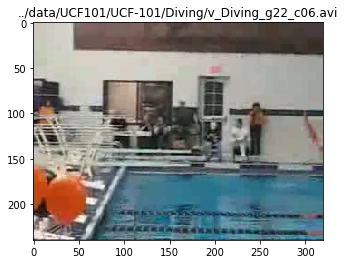

In [26]:
avi.frameShow(avi.getFrame(150), avi._filename)

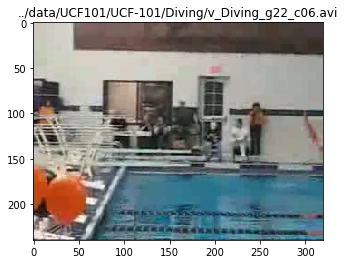

In [7]:
avi.frameShow(avi.getRandomFrame(max_attempts=1), avi._filename)

Let's see what happens when we get a sequence:

We start with a sequence of length 1 (a single frame):

And now we can show a longer sequence:

In [9]:
len(avi)

183

video attributes: {'n-frames': 183, 'frame-height': 240, 'frame-width': 320, 'channels': 3, 'fps': 29.97002997002997, 'frame-index': 0}
Frame 0 is not None
Frame 1 is not None
grabbing frame numbers: 0 - 1


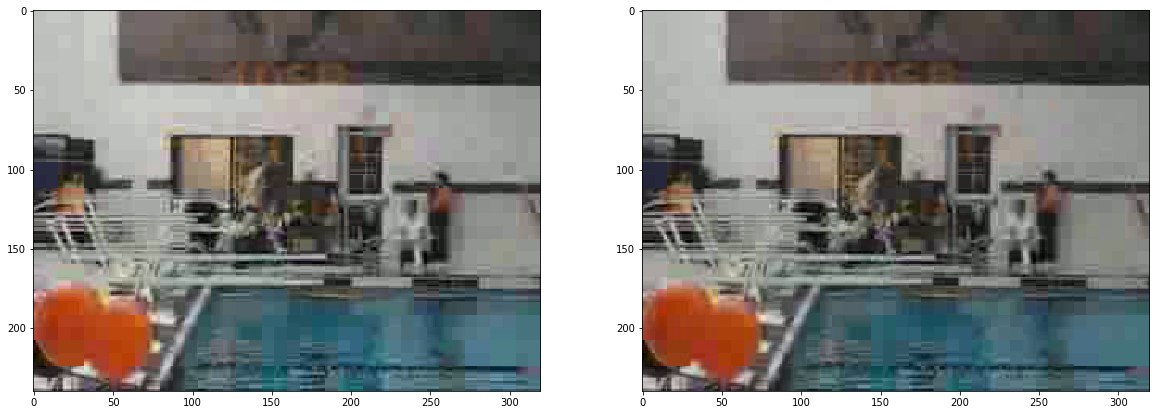

In [10]:
fig = plt.figure(figsize=(20,20))
avi.sequenceShow(avi.getSequence(0, 2))

video attributes: {'n-frames': 183, 'frame-height': 240, 'frame-width': 320, 'channels': 3, 'fps': 29.97002997002997, 'frame-index': 1}
Frame 15 is not None
Frame 16 is not None
grabbing frame numbers: 15 - 16


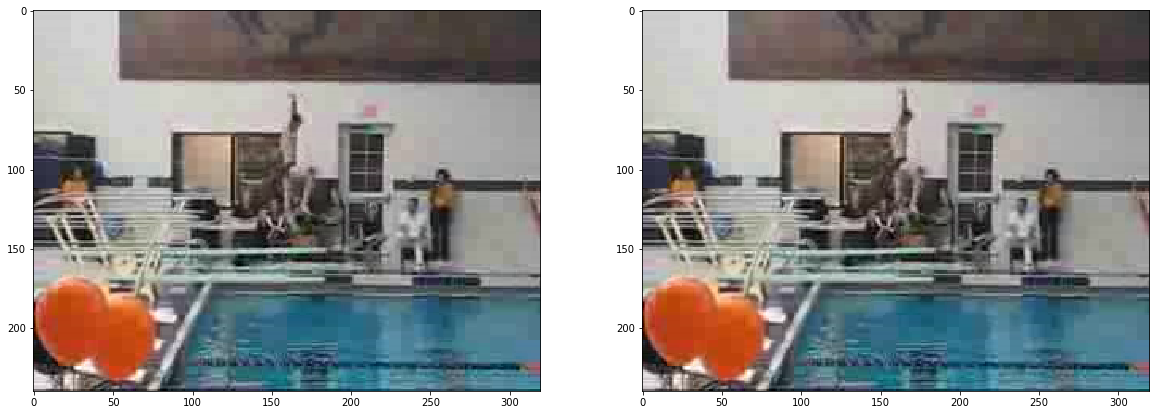

In [11]:
fig = plt.figure(figsize=(20,20))
avi.sequenceShow(avi.getSequence(15, 2, sample_interval=1))

video attributes: {'n-frames': 183, 'frame-height': 240, 'frame-width': 320, 'channels': 3, 'fps': 29.97002997002997, 'frame-index': 16}
Frame 15 is not None
Frame 65 is not None
grabbing frame numbers: 15 - 65


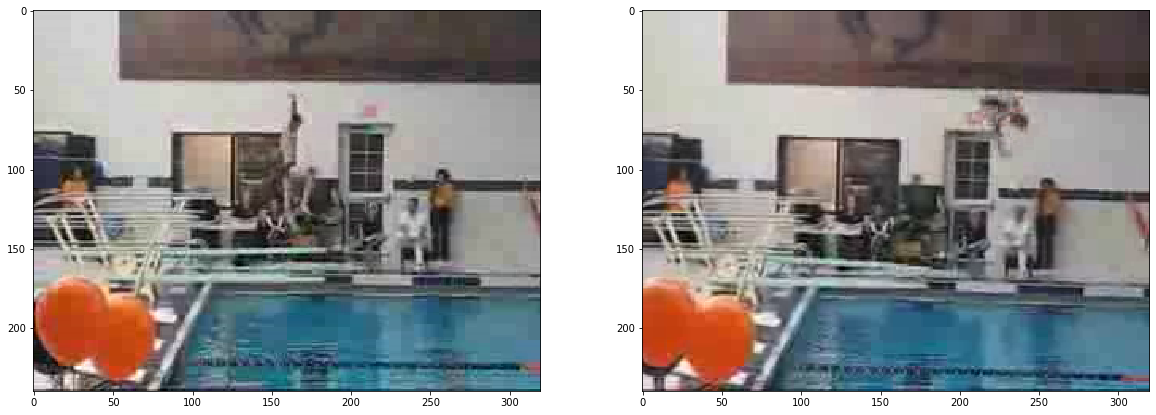

In [12]:
fig = plt.figure(figsize=(20,20))
avi.sequenceShow(avi.getSequence(15, 2, sample_interval=50))

video attributes: {'n-frames': 183, 'frame-height': 240, 'frame-width': 320, 'channels': 3, 'fps': 29.97002997002997, 'frame-index': 65}
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 181.
Safeframe selected. Corrupted frame at index 181 in file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi. Trying with initial frame index 180 
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 180.
Safeframe selected. Corrupted frame at index 181 in file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi. Trying with initial frame index 179 
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 179.
Safeframe selected. Corrupted frame at index 181 in file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi. Trying with initial frame index 178 
Safeframe selected. Good frame found at index 178 in file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi.
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c0

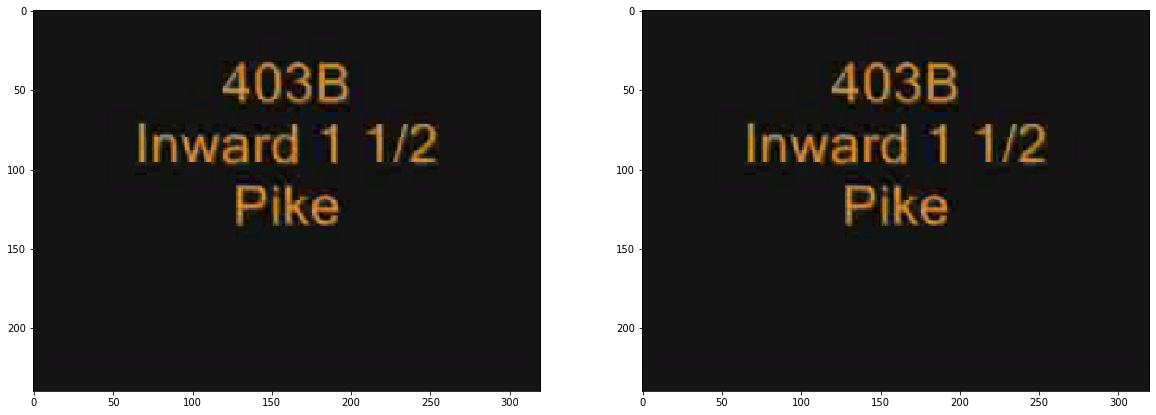

In [13]:
fig = plt.figure(figsize=(20,20))
avi.sequenceShow(avi.getSequence(len(avi)-2, 2, sample_interval=1))

sequence idx_0: 60, sequence_length: 4, num of frames: 183
video attributes: {'n-frames': 183, 'frame-height': 240, 'frame-width': 320, 'channels': 3, 'fps': 29.97002997002997, 'frame-index': 178}
Frame 60 is not None
Frame 61 is not None
Frame 62 is not None
Frame 63 is not None
grabbing frame numbers: 60 - 63


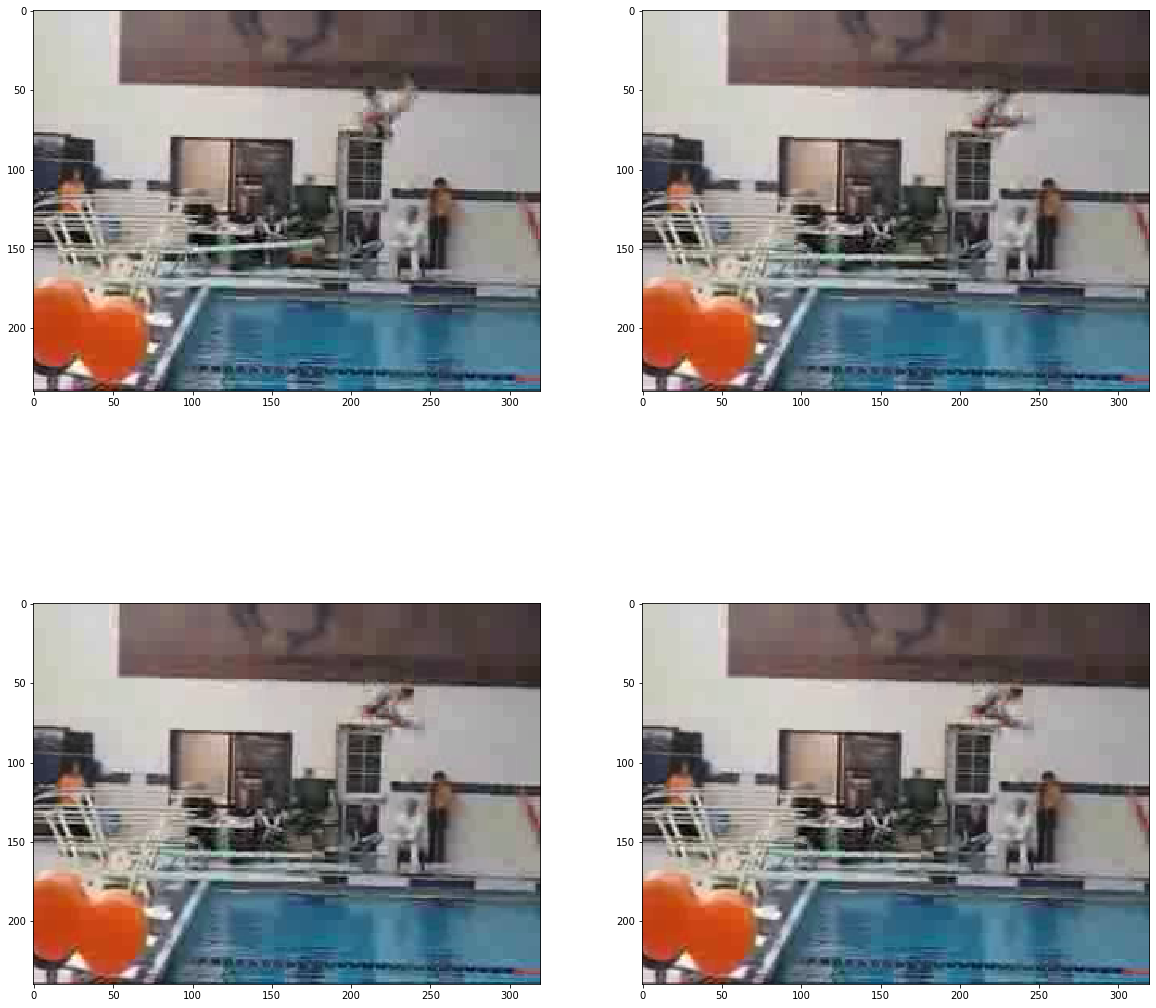

In [14]:
fig = plt.figure(figsize=(20,20))
avi.sequenceShow(avi.getRandomSequence(seq_len=4, sample_interval=1))

The `Diving/v_Diving_g22_c06.avi` file has some correpted frames at the end. We use it to verify what the getSequence does when it detects them.

We first let it throw an exception (`safe=False`).

In [15]:
avi = AVI('../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi', toPIL=True, verbose=True, safe=False)

In [16]:
fig = plt.figure(figsize=(20,20))
avi.sequenceShow(avi.getSequence(len(avi)-2, 2, sample_interval=1))

video attributes: {'n-frames': 183, 'frame-height': 240, 'frame-width': 320, 'channels': 3, 'fps': 29.97002997002997, 'frame-index': 0}
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 181.


Exception: corrupted frame at index 181. No previous non-corrupted frame known for file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi

<Figure size 1440x1440 with 0 Axes>

We now enable the safe frame behaviour. This rolls back until it finds a good frame. Note that in this case, all frames until seq_len is filled will be the same as the first one (since they are all corrupted and replaced with the only good one found).

In [17]:
avi = AVI('../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi', toPIL=True, verbose=True, safe=True)

video attributes: {'n-frames': 183, 'frame-height': 240, 'frame-width': 320, 'channels': 3, 'fps': 29.97002997002997, 'frame-index': 0}
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 179.
Safeframe selected. Corrupted frame at index 179 in file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi. Trying with initial frame index 178 
Safeframe selected. Good frame found at index 178 in file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi.
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 179.
> corrupted frame at index 179 in file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi. Replacing with frame index 178 
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 180.
> corrupted frame at index 180 in file ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi. Replacing with frame index 178 
ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame-index: 181.
> corrupted frame at i

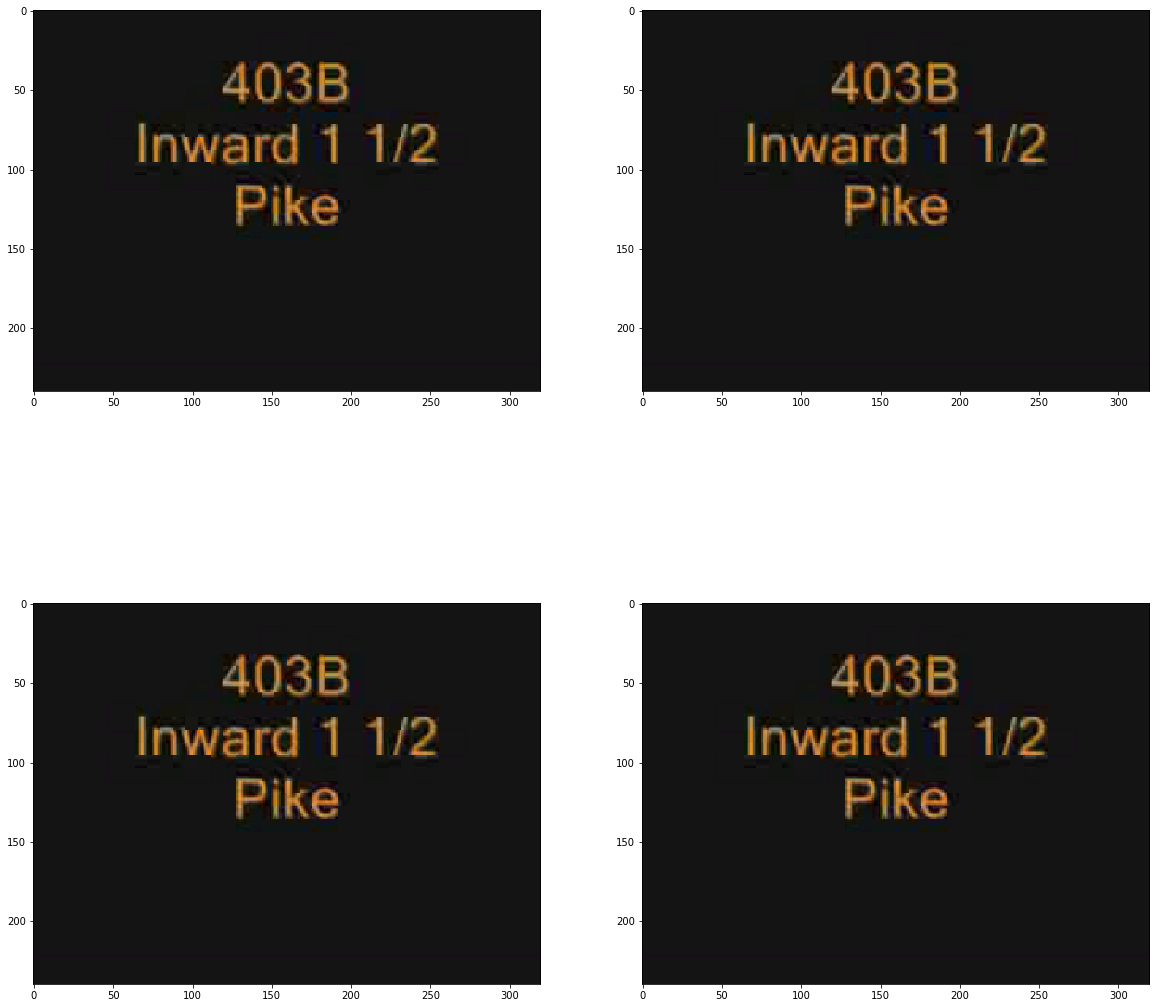

In [18]:
fig = plt.figure(figsize=(20,20))
avi.sequenceShow(avi.getSequence(len(avi)-4, 4, sample_interval=1))

# fin

In [31]:
#hide
from nbdev.export import *
notebook2script()

Converted 01_dataset_ucf101.ipynb.
Converted 02_avi.ipynb.
Converted 04_data_augmentation.ipynb.
Converted 05_models.ipynb.
Converted 06_models-resnet_3d.ipynb.
Converted 07_utils.ipynb.
Converted 10_run-baseline.ipynb.
Converted 11_run-sequence-convlstm.ipynb.
Converted 12_run-sequence-3d.ipynb.
Converted Smaller UCF-dataset-Copy1.ipynb.
Converted Smaller UCF-dataset.ipynb.
Converted index.ipynb.
